# Loading Packages

In [161]:
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datetime
import h5py

In [162]:
from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

# Format the date and time
current_datetime = current_datetime.strftime('%d%m%y')

print(current_datetime)


060624


In [163]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

In [164]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Set the device to the first available GPU
    device = torch.device("cuda:0")
else:
    # If GPU is not available, use the CPU
    device = torch.device("cpu")

In [165]:
# Get the current working directory
current_dir = os.getcwd()

# Define the relative path to the desired directory
relative_path = "data"

# Combine the current directory with the relative path to get the absolute path
absolute_path = os.path.join(current_dir, relative_path)
os.chdir(absolute_path)
#print(os.getcwd())

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\kacpe\\Desktop\\lab_rotation_git\\data\\data'

In [112]:
os.getcwd()

'c:\\Users\\kacpe\\Desktop\\lab_rotation_git\\data'

# HDF5 data

In [18]:
# Open the HDF5 file
file_path = 'C:/Users/kacpe/Desktop/lab_rotation_git/data/hdf_fixed/HVM_20220916_v2.hdf5'
with h5py.File(file_path, 'r') as hdf:
    # List all groups
    print("Keys: %s" % hdf.keys())
    
    # Get the dataset
    dataset = hdf['mapped/arWrist']
    
    # Convert dataset to numpy array
    data = dataset[:]
    
    print(data)

Keys: <KeysViewHDF5 ['data_m_h_filtered_trials', 'data_macaque_unfiltered_trials', 'filtered_full', 'kf_observation_cov_matrix', 'kf_observation_matrix', 'kf_transition_cov_matrix', 'kf_transition_matrix', 'mapParamsaOrigin', 'mapParamsaScale', 'mapParamsaT', 'mapParamsnotes', 'mapParamsoOrigin', 'mapParamsoScale', 'mapParamsoT', 'mapped']>
[[-0.31634832 -0.31397827 -0.31105944 ... -0.31477169 -0.30441075
  -0.26777613]
 [ 0.25825385  0.25781994  0.2619101  ...  0.27716087  0.26708769
   0.24212759]
 [ 0.40910863  0.40281858  0.40857672 ...  0.40230575  0.39229376
   0.35255256]]


In [17]:
data.T.shape

(7803, 3)

In [166]:
def get_dataset_names(group, prefix=''):
    datasets = []
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            datasets.append(prefix + key)
        elif isinstance(item, h5py.Group):
            datasets.extend(get_dataset_names(item, prefix + key + '/'))
    return datasets

# Path to your HDF5 file
file_path = 'HVM_20220916_v2.hdf5'

# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    # Get all dataset names
    dataset_names = get_dataset_names(hdf)
    print("Datasets:", dataset_names)

Datasets: ['data_m_h_filtered_trials/b_1', 'data_m_h_filtered_trials/b_2', 'data_m_h_filtered_trials/b_3', 'data_m_h_filtered_trials/b_4', 'data_m_h_filtered_trials/headTop_confidence', 'data_m_h_filtered_trials/headTop_x', 'data_m_h_filtered_trials/headTop_y', 'data_m_h_filtered_trials/headTop_z', 'data_m_h_filtered_trials/id', 'data_m_h_filtered_trials/index', 'data_m_h_filtered_trials/lAnkle_confidence', 'data_m_h_filtered_trials/lAnkle_x', 'data_m_h_filtered_trials/lAnkle_y', 'data_m_h_filtered_trials/lAnkle_z', 'data_m_h_filtered_trials/lEar_confidence', 'data_m_h_filtered_trials/lEar_x', 'data_m_h_filtered_trials/lEar_y', 'data_m_h_filtered_trials/lEar_z', 'data_m_h_filtered_trials/lElbow_confidence', 'data_m_h_filtered_trials/lElbow_x', 'data_m_h_filtered_trials/lElbow_y', 'data_m_h_filtered_trials/lElbow_z', 'data_m_h_filtered_trials/lHip_confidence', 'data_m_h_filtered_trials/lHip_x', 'data_m_h_filtered_trials/lHip_y', 'data_m_h_filtered_trials/lHip_z', 'data_m_h_filtered_tria

In [150]:
import pandas as pd

# Define the file paths
csv_file_path = 'C:/Users/kacpe/Desktop/lab_rotation_git/data/hdf_fixed/data_h_trials_20220915.csv'
hdf5_file_path = 'C:/Users/kacpe/Desktop/lab_rotation_git/data/hdf_fixed/data_h_trials_20220915.h5'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Create a new HDF5 file and add datasets
with h5py.File(hdf5_file_path, 'w') as hdf:
    for column in df.columns:
        data = df[column].values
        dataset = hdf.create_dataset(column, data=data)
        dataset.attrs['column_name'] = column

print("Transformation from CSV to HDF5 with the correct structure completed successfully.")

Transformation from CSV to HDF5 with the correct structure completed successfully.


# Model Architecture

In [167]:
class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_dim if i == 0 else hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])  # Layer normalization for each GRU cell
        
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h=None):
        if h is None:
            h = [torch.zeros(x.size(0), self.hidden_dim, device=x.device) for _ in range(self.num_layers)] # Initiate first hidden state with zeros 
        
        for t in range(x.size(1)):
            input_t = x[:, t, :]
            for layer_idx, (gru_cell, layer_norm) in enumerate(zip(self.gru_cells, self.layer_norms)):
                h[layer_idx] = gru_cell(input_t, h[layer_idx])
                h[layer_idx] = layer_norm(h[layer_idx])  # Apply layer normalization
                input_t = h[layer_idx]

        out = self.fc(h[-1]) # get output of size output_dim
        out = torch.sigmoid(out) 

        return out, h

# Training functions

In [168]:
# Custom Dataset class for loading data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Implement data retrieval for each index
        input_data = self.X[idx]
        target_data = self.y[idx]
        input_data = input_data.unsqueeze(0)
        
        # Convert data to torch tensors if required
        input_tensor = torch.Tensor(input_data)
        target_tensor = torch.Tensor(target_data)
        
        return input_tensor, target_tensor

In [169]:
def accuracy(correct, total):
    return float(correct)/total


In [170]:
def train(dataloader, model, optimizer, loss_fn, scheduler=None, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device)
    model.train()
    predicted_probs = []
    predicted_labels = []
    hidden_states = []
    for x, y in dataloader:
        x = x.to(device).float()
        y = y.to(device).float()
        
        optimizer.zero_grad()
        hidden_states_batch = []  # Initialize a list to store hidden states for the current batch        
        out, last_hidden_states = model(x)
        y_prob = out 
        # Append the predicted probabilities to the list
        predicted_probs.append(y_prob.cpu().detach().numpy())
        loss = loss_fn(out, y)
        epoch_loss.append(loss.item())

        
        
        y_pred = torch.round(y_prob)
        # Append the batch's hidden states to the list
        for layer_state in last_hidden_states:
            hidden_states_batch.append(layer_state.cpu().detach().numpy())
        epoch_correct += sum((y == y_pred).flatten()).item()
        epoch_total += y.numel()
        # Append the batch's hidden states to the overall hidden_states list
        hidden_states.append(hidden_states_batch)
        
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        predicted_labels.extend(zip(y_pred.cpu().detach().cpu().numpy(), y.cpu().numpy()))

    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs 

In [117]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device).float()
    model.eval()
    predicted_probs = []
    predicted_labels = []
    #hidden_states = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device).float()
            y = y.to(device).float()
            
            out, last_hidden_states = model(x)
            
            loss = loss_fn(out, y)
            epoch_loss.append(loss.item())

            #hidden_states.append(hidden)
            y_pred = out 
            predicted_probs.append(y_pred.cpu().detach().numpy())
            y_pred = torch.round(y_pred)
            epoch_correct += sum((y == y_pred).flatten())
            epoch_total += y.numel()
            predicted_labels.extend(zip(y_pred.cpu().numpy(), y.cpu().numpy()))
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs

In [171]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, schedule_on_train=True, verbose=True):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    #train_hidden_states, val_hidden_states = [], []
    
    for epoch in range(num_epochs):
        epoch_train_loss, epoch_train_acc, train_preds, train_probs = train(train_dataloader, model, optimizer, loss_fn, scheduler, device)
        
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        #train_hidden_states.extend(train_hidden)
        
        if val_dataloader is not None:
            epoch_val_loss, epoch_val_acc, val_preds, val_probs = validate(val_dataloader, model, loss_fn, device)
        
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(epoch_train_loss if schedule_on_train or val_dataloader is None else epoch_val_loss)
        if epoch % 10 == 0:
            val_str = f", val loss: {epoch_val_loss}, val acc: {epoch_val_acc}" if val_dataloader is not None else ""
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, train acc: {epoch_train_acc}{val_str}")
            for param_group in optimizer.param_groups:
               print(f'Current learning rate: {param_group["lr"]}')
        if epoch == num_epochs - 1:  # Store values only for the final epoch
            train_predicted_labels = train_preds
            #val_predicted_labels = val_preds
            train_probs_final = train_probs
            #val_probs_final = val_probs
            if val_dataloader is not None:
                val_predicted_labels = val_preds
                val_probs_final = val_probs

    if val_dataloader is not None:        
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, val_predicted_labels, train_probs_final, val_probs_final
    else: 
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final

In [172]:
def evaluate_model(model, dataloader, y):
    """
    Evaluate the given model using the provided train dataloader and labels.
    
    Args:
    - model: The PyTorch model to evaluate.
    - train_dataloader: The DataLoader for training data.
    - y_train: The ground truth labels for training data.
    - current_datetime: The current date and time for folder naming.

    Returns:
    - mean_accuracy: Mean accuracy for each output state.
    """
    # Set model to evaluation mode
    model.eval()

    # Initialize empty lists to store predictions
    all_preds = []
    all_probs = []

    # Iterate through the train data batches
    for inputs, _ in dataloader:
        inputs = inputs.float()
        with torch.no_grad():
            probabilities, _ = model(inputs)
            
            preds = torch.round(probabilities)

        # Append predictions to the list
        all_preds.append(preds.numpy())
        all_probs.append(probabilities.numpy())

    # Concatenate the predicted batches
    all_preds_array = np.concatenate(all_preds, axis=0)
    all_probs_array = np.concatenate(all_probs, axis=0)

    # Define column names
    columns = ['s_1', 's_2', 's_3', 's_4']

    # Create DataFrames from NumPy arrays
    all_probs_df = pd.DataFrame(all_probs_array, columns=columns)
    predictions_df = pd.DataFrame(all_preds_array, columns=y.columns, index=y.index)

    # Calculate accuracy for each output state
    accuracies = (predictions_df == y).mean()

    # Print and save accuracy results
    mean_accuracy = np.mean(accuracies)
    print("Accuracy for each output state:")
    print(mean_accuracy)

    return mean_accuracy, all_probs_array 

In [173]:
def save_results(file_path, value_to_save):
    """
    Save a value to a file, creating the file if it doesn't exist.
    
    Args:
    - file_path: The path to the file.
    - value_to_save: The value to save to the file.
    """
    try:
        # Check if the file exists
        if not os.path.exists(file_path):
            # If the file doesn't exist, create it
            with open(file_path, "w") as file:
                pass  # Empty pass to create an empty file

        # Open the file in append mode and write the value
        with open(file_path, "a") as file:
            file.write(value_to_save + '\n')
            print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")

# training loop 

In [174]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
data = "data_m_trials.csv"
# Read the CSV file
df = pd.read_csv(data)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['trial']] = df[['trial']]
cols_to_omit = ['trial']
columns_to_shift = ['s_1','s_2','s_3','s_4']
columns_to_shift

['s_1', 's_2', 's_3', 's_4']

In [131]:
# Hyperparameters
input_dim = 4
hidden_dim = 4
output_dim = 4
num_layers = 1
n_epochs =100
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

loss_fn = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True, threshold=0.01, threshold_mode='rel')

In [132]:
model_probabilities_s = {}

for j in np.arange(1,25):
    for i in np.arange(10,101,step=10):
        shift = i
        set_values = j
        model_name = 's_'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['trial', 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        
        trial_groups = shifted_df.groupby('trial')
        
        # Get a list of trial group names (trial IDs)
        trial_ids = list(trial_groups.groups.keys())
        
        # Shuffle the trial IDs randomly 
        random.shuffle(trial_ids)
        # Create an empty list to store shuffled trial DataFrames
        shuffled_trial_dfs = []
        
        # Iterate through the shuffled trial IDs and add the corresponding trial DataFrames to the list
        for trial_id in trial_ids:
            shuffled_trial_dfs.append(trial_groups.get_group(trial_id))
            
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['trial'])
        full_set = shifted_df.drop(columns=['trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = os.path.join(current_dir, 'models')
        dir_name = "model_s_" + current_datetime
        folder_path = os.path.join(folder_path, dir_name)

        try:
            # Check if the directory exists, if not, create it
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)

            # Combine the folder path and model filename
            model_filename = model_name + '.pth'
            full_model = os.path.join(folder_path, model_filename)

            # Save the model to the specified folder
            #torch.save(state_dict, full_model)
            print("Model saved successfully at:", full_model)
        except Exception as e:
            print("An error occurred:", e)

            # Evaluate the model on the test set and store the probabilities
        accs, train_probs = evaluate_model(model, train_dataloader, y_train)

        # Save the probabilities to the dictionary
        model_probabilities_s[model_name] = train_probs  
        # Define the directory where you want to save the file relative to current_dir
        relative_dir = "results/"

        # Create the full directory path by joining current_dir and relative_dir
        full_dir_path = os.path.join(current_dir, relative_dir)

        # Ensure that the directory exists, if not, create it
        if not os.path.exists(full_dir_path):
            os.makedirs(full_dir_path)

        # Define the file name
        file_name = 's_results_train_' + current_datetime + '.txt'

        # Create the full file path by joining the directory path and the file name
        file_path = os.path.join(full_dir_path, file_name)

        # Define the value you want to save
        value_to_save = model_name + ": " + str(accs)

        try:
            # Open the file in append mode (create if it doesn't exist)
            with open(file_path, "a+") as file:
                # Move the file cursor to the beginning to check if the file is empty
                file.seek(0)
                # Read the first character of the file
                first_char = file.read(1)
                # If the first character is empty (file is empty), write a new line
                if not first_char:
                    file.write('\n')
                # Write the value to the file
                file.write(value_to_save + '\n')
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")
            
        accs, test_probs = evaluate_model(model, test_dataloader, y_test)

        # Define the directory where you want to save the file relative to current_dir
        relative_dir = "results/"

        # Create the full directory path by joining current_dir and relative_dir
        full_dir_path = os.path.join(current_dir, relative_dir)

        # Ensure that the directory exists, if not, create it
        if not os.path.exists(full_dir_path):
            os.makedirs(full_dir_path)

        # Define the file name
        file_name = 's_results_test' + current_datetime + '.txt'

        # Create the full file path by joining the directory path and the file name
        file_path = os.path.join(full_dir_path, file_name)

        # Define the value you want to save
        value_to_save = model_name + ": " + str(accs)

        try:
            # Open the file in append mode (create if it doesn't exist)
            with open(file_path, "a+") as file:
                # Move the file cursor to the beginning to check if the file is empty
                file.seek(0)
                # Read the first character of the file
                first_char = file.read(1)
                # If the first character is empty (file is empty), write a new line
                if not first_char:
                    file.write('\n')
                # Write the value to the file
                file.write(value_to_save + '\n')
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")

Epoch 0, train loss: 0.7988843321800232, train acc: 0.45188656378767067
Current learning rate: 0.01
Epoch 10, train loss: 0.6238760352134705, train acc: 0.6569645309848914
Current learning rate: 0.01
Epoch 20, train loss: 0.5399971008300781, train acc: 0.8249979801244244
Current learning rate: 0.01
Epoch 30, train loss: 0.4671573042869568, train acc: 0.8865435889149228
Current learning rate: 0.01
Epoch 40, train loss: 0.40540069341659546, train acc: 0.8873919366567019
Current learning rate: 0.01
Epoch 50, train loss: 0.34916168451309204, train acc: 0.918033449139533
Current learning rate: 0.01
Epoch 60, train loss: 0.2925545573234558, train acc: 0.9464127009776198
Current learning rate: 0.01
Epoch 70, train loss: 0.24603843688964844, train acc: 0.955966712450513
Current learning rate: 0.01
Epoch 80, train loss: 0.20616492629051208, train acc: 0.9570170477498586
Current learning rate: 0.01
Epoch 90, train loss: 0.17947332561016083, train acc: 0.9570170477498586
Current learning rate: 0.

In [133]:
current_dir

'c:\\Users\\kacpe\\Desktop\\lab_rotation_git\\data'

In [188]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_m_trials.csv"
# Read the CSV file

df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['trial']] = df[['trial']]
cols_to_omit = ['trial']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['nose_x', 'nose_y', 'nose_z', 'headTop_x', 'headTop_y', 'headTop_z',
       'neck_x', 'neck_y', 'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z',
       'lEar_x', 'lEar_y', 'lEar_z', 'lShoulder_x', 'lShoulder_y',
       'lShoulder_z', 'lElbow_x', 'lElbow_y', 'lElbow_z', 'lWrist_x',
       'lWrist_y', 'lWrist_z', 'lHip_x', 'lHip_y', 'lHip_z', 'rEar_x',
       'rEar_y', 'rEar_z', 'rShoulder_x', 'rShoulder_y', 'rShoulder_z',
       'rElbow_x', 'rElbow_y', 'rElbow_z', 'rWrist_x', 'rWrist_y', 'rWrist_z',
       'rHip_x', 'rHip_y', 'rHip_z', 's_1', 's_2', 's_3', 's_4', 'b_1', 'b_2',
       'b_3', 'b_4'],
      dtype='object')

In [135]:
scaled_df.columns

Index(['nose_x', 'nose_y', 'nose_z', 'headTop_x', 'headTop_y', 'headTop_z',
       'neck_x', 'neck_y', 'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z',
       'lEar_x', 'lEar_y', 'lEar_z', 'lShoulder_x', 'lShoulder_y',
       'lShoulder_z', 'lElbow_x', 'lElbow_y', 'lElbow_z', 'lWrist_x',
       'lWrist_y', 'lWrist_z', 'lHip_x', 'lHip_y', 'lHip_z', 'rEar_x',
       'rEar_y', 'rEar_z', 'rShoulder_x', 'rShoulder_y', 'rShoulder_z',
       'rElbow_x', 'rElbow_y', 'rElbow_z', 'rWrist_x', 'rWrist_y', 'rWrist_z',
       'rHip_x', 'rHip_y', 'rHip_z', 's_1', 's_2', 's_3', 's_4', 'b_1', 'b_2',
       'b_3', 'b_4', 'trial'],
      dtype='object')

In [190]:
# Hyperparameters
input_dim = 46
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =50
lr = 0.001

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True, threshold=0.01, threshold_mode='rel')

In [191]:
model_probabilities_sm = {}
for j in np.arange(1,25):
    for i in np.arange(10,101,step=20):
        shift = i
        set_values = j
        model_name = 's_m'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        
        trial_groups = shifted_df.groupby('trial')
        
        # Get a list of trial group names (trial IDs)
        trial_ids = list(trial_groups.groups.keys())
        
        # Shuffle the trial IDs randomly 
        random.shuffle(trial_ids)
        # Create an empty list to store shuffled trial DataFrames
        shuffled_trial_dfs = []
        
        # Iterate through the shuffled trial IDs and add the corresponding trial DataFrames to the list
        for trial_id in trial_ids:
            shuffled_trial_dfs.append(trial_groups.get_group(trial_id))
            
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['trial'])
        full_set = shifted_df.drop(columns=['trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=None)


        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = os.path.join(current_dir, 'models')
        dir_name = "model_sm_" + current_datetime
        folder_path = os.path.join(folder_path, dir_name)

        try:
            # Check if the directory exists, if not, create it
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)

            # Combine the folder path and model filename
            model_filename = model_name + '.pth'
            full_model = os.path.join(folder_path, model_filename)

            # Save the model to the specified folder
            torch.save(state_dict, full_model)
            print("Model saved successfully at:", full_model)
        except Exception as e:
            print("An error occurred:", e)



                # Evaluate the model on the test set and store the probabilities
        accs, test_probs = evaluate_model(model, test_dataloader, y_test)

        # Save the probabilities to the dictionary
        model_probabilities_sm[model_name] = test_probs
        # Define the directory where you want to save the file relative to current_dir
        relative_dir = "results/"

        # Create the full directory path by joining current_dir and relative_dir
        full_dir_path = os.path.join(current_dir, relative_dir)

        # Ensure that the directory exists, if not, create it
        if not os.path.exists(full_dir_path):
            os.makedirs(full_dir_path)

        # Define the file name
        file_name = 'sm_results_train_' + current_datetime + '.txt'

        # Create the full file path by joining the directory path and the file name
        file_path = os.path.join(full_dir_path, file_name)

        # Define the value you want to save
        value_to_save = model_name + ": " + str(accs)

        try:
            # Open the file in append mode (create if it doesn't exist)
            with open(file_path, "a+") as file:
                # Move the file cursor to the beginning to check if the file is empty
                file.seek(0)
                # Read the first character of the file
                first_char = file.read(1)
                # If the first character is empty (file is empty), write a new line
                if not first_char:
                    file.write('\n')
                # Write the value to the file
                file.write(value_to_save + '\n')
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")
            
        accs, train_probs = evaluate_model(model, train_dataloader, y_train)

        # Define the directory where you want to save the file relative to current_dir
        relative_dir = "results/"

        # Create the full directory path by joining current_dir and relative_dir
        full_dir_path = os.path.join(current_dir, relative_dir)

        # Ensure that the directory exists, if not, create it
        if not os.path.exists(full_dir_path):
            os.makedirs(full_dir_path)

        # Define the file name
        file_name = 'sm_results_test_' + current_datetime + '.txt'

        # Create the full file path by joining the directory path and the file name
        file_path = os.path.join(full_dir_path, file_name)

        # Define the value you want to save
        value_to_save = model_name + ": " + str(accs)

        try:
            # Open the file in append mode (create if it doesn't exist)
            with open(file_path, "a+") as file:
                # Move the file cursor to the beginning to check if the file is empty
                file.seek(0)
                # Read the first character of the file
                first_char = file.read(1)
                # If the first character is empty (file is empty), write a new line
                if not first_char:
                    file.write('\n')
                # Write the value to the file
                file.write(value_to_save + '\n')
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")

Epoch 0, train loss: 0.7002652287483215, train acc: 0.5304395249252646
Current learning rate: 0.001
Epoch 10, train loss: 0.6088550686836243, train acc: 0.6537731275753413
Current learning rate: 0.001
Epoch 20, train loss: 0.5736750364303589, train acc: 0.711097196412701
Current learning rate: 0.001
Epoch 30, train loss: 0.5201502442359924, train acc: 0.7946392502221863
Current learning rate: 0.001
Epoch 40, train loss: 0.42548370361328125, train acc: 0.8686878888260483
Current learning rate: 0.001
Model saved successfully at: c:\Users\kacpe\Desktop\lab_rotation_git\data\models\model_sm_060624\s_m10_val1.pth
Accuracy for each output state:
0.9801324503311258
Value 's_m10_val1: 0.9801324503311258' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sm_results_train_060624.txt' successfully.
Accuracy for each output state:
0.9440494465540922
Value 's_m10_val1: 0.9440494465540922' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sm_results_test_060624.txt' success

In [141]:
load_and_evaluate_models_with_shift_10("C:/Users/kacpe/Desktop/lab_rotation_git/data/models/model_sm_120524")

ValueError: could not determine the shape of object type 'DataFrame'

In [183]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

df_human = pd.read_csv("data_h_trials.csv")
df_human = df_human.drop(columns=['s_1','s_2','s_3','s_4','trial'])
data = "data_m_trials.csv"
# Read the CSV file
df = pd.read_csv(data)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
print(df.columns)

print(df[['trial']])
print(df.columns)
#df = df.drop(columns=['trial'])
scaled_df[['trial']] = df[['trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['trial']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['H_headTop_x', 'H_headTop_y', 'H_headTop_z', 'H_neck_x', 'H_neck_y',
       'H_neck_z', 'H_tailBase_x', 'H_tailBase_y', 'H_tailBase_z', 'H_lEar_x',
       'H_lEar_y', 'H_lEar_z', 'H_lShoulder_x', 'H_lShoulder_y',
       'H_lShoulder_z', 'H_lElbow_x', 'H_lElbow_y', 'H_lElbow_z', 'H_lWrist_x',
       'H_lWrist_y', 'H_lWrist_z', 'H_lHip_x', 'H_lHip_y', 'H_lHip_z',
       'H_rEar_x', 'H_rEar_y', 'H_rEar_z', 'H_rShoulder_x', 'H_rShoulder_y',
       'H_rShoulder_z', 'H_rHip_x', 'H_rHip_y', 'H_rHip_z', 'trial', 'nose_x',
       'nose_y', 'nose_z', 'headTop_x', 'headTop_y', 'headTop_z', 'neck_x',
       'neck_y', 'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z', 'lEar_x',
       'lEar_y', 'lEar_z', 'lShoulder_x', 'lShoulder_y', 'lShoulder_z',
       'lElbow_x', 'lElbow_y', 'lElbow_z', 'lWrist_x', 'lWrist_y', 'lWrist_z',
       'lHip_x', 'lHip_y', 'lHip_z', 'rEar_x', 'rEar_y', 'rEar_z',
       'rShoulder_x', 'rShoulder_y', 'rShoulder_z', 'rElbow_x', 'rElbow_y',
       'rElbow_z', 'rWri

Index(['H_headTop_x', 'H_headTop_y', 'H_headTop_z', 'H_neck_x', 'H_neck_y',
       'H_neck_z', 'H_tailBase_x', 'H_tailBase_y', 'H_tailBase_z', 'H_lEar_x',
       'H_lEar_y', 'H_lEar_z', 'H_lShoulder_x', 'H_lShoulder_y',
       'H_lShoulder_z', 'H_lElbow_x', 'H_lElbow_y', 'H_lElbow_z', 'H_lWrist_x',
       'H_lWrist_y', 'H_lWrist_z', 'H_lHip_x', 'H_lHip_y', 'H_lHip_z',
       'H_rEar_x', 'H_rEar_y', 'H_rEar_z', 'H_rShoulder_x', 'H_rShoulder_y',
       'H_rShoulder_z', 'H_rHip_x', 'H_rHip_y', 'H_rHip_z', 'nose_x', 'nose_y',
       'nose_z', 'headTop_x', 'headTop_y', 'headTop_z', 'neck_x', 'neck_y',
       'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z', 'lEar_x', 'lEar_y',
       'lEar_z', 'lShoulder_x', 'lShoulder_y', 'lShoulder_z', 'lElbow_x',
       'lElbow_y', 'lElbow_z', 'lWrist_x', 'lWrist_y', 'lWrist_z', 'lHip_x',
       'lHip_y', 'lHip_z', 'rEar_x', 'rEar_y', 'rEar_z', 'rShoulder_x',
       'rShoulder_y', 'rShoulder_z', 'rElbow_x', 'rElbow_y', 'rElbow_z',
       'rWrist_x', 'r

In [186]:
# Hyperparameters
input_dim = 79
hidden_dim = 46
output_dim = 4
num_layers = 1
n_epochs =50
lr = 0.001

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

loss_fn = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=10, verbose=True, threshold=0.01, threshold_mode='rel')

In [128]:
scaled_df.columns

Index(['H_headTop_x', 'H_headTop_y', 'H_headTop_z', 'H_neck_x', 'H_neck_y',
       'H_neck_z', 'H_tailBase_x', 'H_tailBase_y', 'H_tailBase_z', 'H_lEar_x',
       'H_lEar_y', 'H_lEar_z', 'H_lShoulder_x', 'H_lShoulder_y',
       'H_lShoulder_z', 'H_lElbow_x', 'H_lElbow_y', 'H_lElbow_z', 'H_lWrist_x',
       'H_lWrist_y', 'H_lWrist_z', 'H_lHip_x', 'H_lHip_y', 'H_lHip_z',
       'H_rEar_x', 'H_rEar_y', 'H_rEar_z', 'H_rShoulder_x', 'H_rShoulder_y',
       'H_rShoulder_z', 'H_rHip_x', 'H_rHip_y', 'H_rHip_z', 'nose_x', 'nose_y',
       'nose_z', 'headTop_x', 'headTop_y', 'headTop_z', 'neck_x', 'neck_y',
       'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z', 'lEar_x', 'lEar_y',
       'lEar_z', 'lShoulder_x', 'lShoulder_y', 'lShoulder_z', 'lElbow_x',
       'lElbow_y', 'lElbow_z', 'lWrist_x', 'lWrist_y', 'lWrist_z', 'lHip_x',
       'lHip_y', 'lHip_z', 'rEar_x', 'rEar_y', 'rEar_z', 'rShoulder_x',
       'rShoulder_y', 'rShoulder_z', 'rElbow_x', 'rElbow_y', 'rElbow_z',
       'rWrist_x', 'r

In [187]:
model_probabilities_smh = {}
for j in np.arange(1,25):
    for i in np.arange(10,101,step=20):
        shift = i
        set_values = j
        model_name = 's_m_h'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
      
        selected_columns = ['trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headTop_x_minus_'+str(shift), 'H_headTop_y_minus_'+str(shift), 'H_headTop_z_minus_'+str(shift), 
        'H_neck_x_minus_'+str(shift), 'H_neck_y_minus_'+str(shift),
       'H_neck_z_minus_'+str(shift), 'H_tailBase_x_minus_'+str(shift), 'H_tailBase_y_minus_'+str(shift), 'H_tailBase_z_minus_'+str(shift), 'H_lEar_x_minus_'+str(shift),
       'H_lEar_y_minus_'+str(shift), 'H_lEar_z_minus_'+str(shift), 'H_lShoulder_x_minus_'+str(shift), 'H_lShoulder_y_minus_'+str(shift),
       'H_lShoulder_z_minus_'+str(shift), 'H_lElbow_x_minus_'+str(shift), 'H_lElbow_y_minus_'+str(shift), 'H_lElbow_z_minus_'+str(shift), 'H_lWrist_x_minus_'+str(shift),
       'H_lWrist_y_minus_'+str(shift), 'H_lWrist_z_minus_'+str(shift), 'H_lHip_x_minus_'+str(shift), 'H_lHip_y_minus_'+str(shift), 'H_lHip_z_minus_'+str(shift),
       'H_rEar_x_minus_'+str(shift), 'H_rEar_y_minus_'+str(shift), 'H_rEar_z_minus_'+str(shift), 'H_rShoulder_x_minus_'+str(shift), 'H_rShoulder_y_minus_'+str(shift),
       'H_rShoulder_z_minus_'+str(shift), 'H_rHip_x_minus_'+str(shift), 'H_rHip_y_minus_'+str(shift), 'H_rHip_z_minus_'+str(shift)]
        shifted_df = shifted_df[selected_columns]
        
        trial_groups = shifted_df.groupby('trial')
        
        # Get a list of trial group names (trial IDs)
        trial_ids = list(trial_groups.groups.keys())
        
        # Shuffle the trial IDs randomly 
        random.shuffle(trial_ids)
        # Create an empty list to store shuffled trial DataFrames
        shuffled_trial_dfs = []
        
        # Iterate through the shuffled trial IDs and add the corresponding trial DataFrames to the list
        for trial_id in trial_ids:
            shuffled_trial_dfs.append(trial_groups.get_group(trial_id))
            
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['trial'])
        full_set = shifted_df.drop(columns=['trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=None)


        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = os.path.join(current_dir, 'models')
        dir_name = "model_smh_" + current_datetime
        folder_path = os.path.join(folder_path, dir_name)

        try:
            # Check if the directory exists, if not, create it
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)

            # Combine the folder path and model filename
            model_filename = model_name + '.pth'
            full_model = os.path.join(folder_path, model_filename)

            # Save the model to the specified folder
            torch.save(state_dict, full_model)
            print("Model saved successfully at:", full_model)
        except Exception as e:
            print("An error occurred:", e)



                # Evaluate the model on the test set and store the probabilities
        accs, test_probs = evaluate_model(model, train_dataloader, y_train)
        
        
        # Save the probabilities to the dictionary
        
        
        # Define the directory where you want to save the file relative to current_dir
        relative_dir = "results/"

        # Create the full directory path by joining current_dir and relative_dir
        full_dir_path = os.path.join(current_dir, relative_dir)

        # Ensure that the directory exists, if not, create it
        if not os.path.exists(full_dir_path):
            os.makedirs(full_dir_path)

        # Define the file name
        file_name = 'smh_results_train_' + current_datetime + '.txt'

        # Create the full file path by joining the directory path and the file name
        file_path = os.path.join(full_dir_path, file_name)

        # Define the value you want to save
        value_to_save = model_name + ": " + str(accs)

        try:
            # Open the file in append mode (create if it doesn't exist)
            with open(file_path, "a+") as file:
                # Move the file cursor to the beginning to check if the file is empty
                file.seek(0)
                # Read the first character of the file
                first_char = file.read(1)
                # If the first character is empty (file is empty), write a new line
                if not first_char:
                    file.write('\n')
                # Write the value to the file
                file.write(value_to_save + '\n')
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")
            
        accs, test_probs = evaluate_model(model, test_dataloader, y_test)
        model_probabilities_smh[model_name] = test_probs

        # Define the directory where you want to save the file relative to current_dir
        relative_dir = "results/"

        # Create the full directory path by joining current_dir and relative_dir
        full_dir_path = os.path.join(current_dir, relative_dir)

        # Ensure that the directory exists, if not, create it
        if not os.path.exists(full_dir_path):
            os.makedirs(full_dir_path)

        # Define the file name
        file_name = 'smh_results_test_' + current_datetime + '.txt'

        # Create the full file path by joining the directory path and the file name
        file_path = os.path.join(full_dir_path, file_name)

        # Define the value you want to save
        value_to_save = model_name + ": " + str(accs)

        try:
            # Open the file in append mode (create if it doesn't exist)
            with open(file_path, "a+") as file:
                # Move the file cursor to the beginning to check if the file is empty
                file.seek(0)
                # Read the first character of the file
                first_char = file.read(1)
                # If the first character is empty (file is empty), write a new line
                if not first_char:
                    file.write('\n')
                # Write the value to the file
                file.write(value_to_save + '\n')
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")

Epoch 0, train loss: 0.9281323552131653, train acc: 0.41276157388704854
Current learning rate: 0.001
Epoch 10, train loss: 0.6068940758705139, train acc: 0.6455522339823867
Current learning rate: 0.001
Epoch 20, train loss: 0.5807633996009827, train acc: 0.7167124505130484
Current learning rate: 0.001
Epoch 30, train loss: 0.5391530990600586, train acc: 0.7656944332229134
Current learning rate: 0.001
Epoch 40, train loss: 0.4890581965446472, train acc: 0.8120101801729014
Current learning rate: 0.001
Model saved successfully at: c:\Users\kacpe\Desktop\lab_rotation_git\data\models\model_smh_060624\s_m_h10_val1.pth
Accuracy for each output state:
0.8592752686434515
Value 's_m_h10_val1: 0.8592752686434515' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/smh_results_train_060624.txt' successfully.
Accuracy for each output state:
0.859271523178808
Value 's_m_h10_val1: 0.859271523178808' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/smh_results_test_060624.txt'

In [107]:
df_human

,H_trial,H_headFront_x,H_headFront_y,H_headFront_z,H_neck_x,H_neck_y,H_neck_z,H_lowerBack_x,H_lowerBack_y,H_lowerBack_z,H_leftWrist_x,H_leftWrist_y,H_leftWrist_z,H_leftShoulder_x,H_leftShoulder_y,H_leftShoulder_z,H_leftElbow_x,H_leftElbow_y,H_leftElbow_z
0,1,-319.182251,-253.413269,2013.931763,-268.469482,-297.380310,1812.766602,-352.833252,-76.865723,2226.392334,-344.622009,-246.639893,2019.190430,-425.375885,-317.520904,1876.492310,-458.945709,-309.872467,2048.477295
1,1,-324.872436,-255.882629,2016.539551,-263.227966,-296.758057,1813.049438,-360.311523,-78.408447,2227.193848,-345.930542,-249.307251,2021.375488,-422.411987,-318.436798,1876.579102,-436.157471,-327.209900,2036.989624
2,1,-332.380615,-261.737793,2014.869141,-254.867188,-296.355347,1814.720215,-359.428528,-69.636169,2221.894531,-348.753113,-254.797485,2016.734619,-418.704559,-322.233612,1875.052246,-400.277313,-308.417908,2049.014404
3,1,-337.492493,-264.044373,2015.822754,-253.528503,-296.733398,1815.203247,-359.707092,-69.354614,2217.768799,-351.482544,-256.398376,2017.758911,-416.974335,-320.470489,1875.497314,-398.561432,-275.742554,2060.052246
4,1,-330.787109,-264.502014,2002.354492,-251.745483,-298.533997,1811.950806,-359.348144,-70.512451,2221.918945,-347.486755,-257.900208,2005.883301,-415.832458,-326.069275,1875.513550,-404.490906,-328.927399,2061.694336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11912,24,-403.301086,-267.773499,2014.829468,-317.219360,-284.069122,1822.362793,-400.221741,-27.564392,2244.171143,-407.652771,-271.567688,2012.903442,-488.185761,-316.715668,1898.187012,-402.754394,-270.214477,2019.482178
11913,24,-403.314880,-268.926880,2011.905396,-316.022217,-283.348663,1823.223145,-400.498779,-30.999390,2248.340332,-407.682861,-273.004883,2009.578369,-488.687164,-318.371887,1897.827026,-402.518433,-271.180115,2016.379639
11914,24,-403.983032,-267.938660,2011.908203,-316.159180,-283.932800,1823.801636,-401.623230,-30.694214,2247.829102,-408.108826,-272.031311,2009.648315,-488.753418,-318.997650,1898.513916,-403.305176,-270.377502,2016.279175
11915,24,-403.286682,-268.732117,2012.065918,-315.250977,-283.880829,1823.621582,-401.562012,-28.688782,2247.002686,-407.466065,-272.705872,2009.787476,-488.310883,-319.353272,1898.354492,-402.506897,-271.092834,2016.531250


In [74]:
df = pd.read_csv("data_human_jarvis_oldlabels.csv")
df.rename(columns={'H_trial': 'trial'}, inplace=True)
# List of column names to drop
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['trial','s_1','s_2','s_3','s_4'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['trial','s_1','s_2','s_3','s_4']] = df[['trial','s_1','s_2','s_3','s_4']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['trial']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift



Index(['H_headFront_x', 'H_headFront_y', 'H_headFront_z', 'H_neck_x',
       'H_neck_y', 'H_neck_z', 'H_lowerBack_x', 'H_lowerBack_y',
       'H_lowerBack_z', 'H_leftWrist_x', 'H_leftWrist_y', 'H_leftWrist_z',
       'H_leftShoulder_x', 'H_leftShoulder_y', 'H_leftShoulder_z',
       'H_leftElbow_x', 'H_leftElbow_y', 'H_leftElbow_z', 's_1', 's_2', 's_3',
       's_4'],
      dtype='object')

In [76]:
scaled_df.trial == 24


0        False
1        False
2        False
3        False
4        False
         ...  
11912     True
11913     True
11914     True
11915     True
11916     True
Name: trial, Length: 11904, dtype: bool

In [43]:
# Hyperparameters
input_dim = scaled_df.shape[1]-1
hidden_dim = 11
output_dim = 4
num_layers = 1
n_epochs =100
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
#class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=None)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [44]:
for j in np.arange(1,25):
    for i in np.arange(0,101,step=10):
        shift = i
        set_values = j
        model_name = 's_h'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['trial', 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
        shifted_df = shifted_df[selected_columns]
        
        trial_groups = shifted_df.groupby('trial')
        
        # Get a list of trial group names (trial IDs)
        trial_ids = list(trial_groups.groups.keys())
        
        # Shuffle the trial IDs randomly 
        random.shuffle(trial_ids)
        # Create an empty list to store shuffled trial DataFrames
        shuffled_trial_dfs = []
        
        # Iterate through the shuffled trial IDs and add the corresponding trial DataFrames to the list
        for trial_id in trial_ids:
            shuffled_trial_dfs.append(trial_groups.get_group(trial_id))
            
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['trial'])
        full_set = shifted_df.drop(columns=['trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)


        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = os.path.join(current_dir, 'models')
        dir_name = "model_sh_" + current_datetime
        folder_path = os.path.join(folder_path, dir_name)

        try:
            # Check if the directory exists, if not, create it
            if not os.path.exists(folder_path):
                os.makedirs(folder_path)

            # Combine the folder path and model filename
            model_filename = model_name + '.pth'
            full_model = os.path.join(folder_path, model_filename)

            # Save the model to the specified folder
            torch.save(state_dict, full_model)
            print("Model saved successfully at:", full_model)
        except Exception as e:
            print("An error occurred:", e)



        accs = evaluate_model(model, train_dataloader, y_train, current_datetime)
        
        # Define the directory where you want to save the file relative to current_dir
        relative_dir = "results/"

        # Create the full directory path by joining current_dir and relative_dir
        full_dir_path = os.path.join(current_dir, relative_dir)

        # Ensure that the directory exists, if not, create it
        if not os.path.exists(full_dir_path):
            os.makedirs(full_dir_path)

        # Define the file name
        file_name = 'sh_results_train_' + current_datetime + '.txt'

        # Create the full file path by joining the directory path and the file name
        file_path = os.path.join(full_dir_path, file_name)

        # Define the value you want to save
        value_to_save = model_name + ": " + str(accs)

        try:
            # Open the file in append mode (create if it doesn't exist)
            with open(file_path, "a+") as file:
                # Move the file cursor to the beginning to check if the file is empty
                file.seek(0)
                # Read the first character of the file
                first_char = file.read(1)
                # If the first character is empty (file is empty), write a new line
                if not first_char:
                    file.write('\n')
                # Write the value to the file
                file.write(value_to_save + '\n')
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")
            
        accs = evaluate_model(model, test_dataloader, y_test, current_datetime)

        # Define the directory where you want to save the file relative to current_dir
        relative_dir = "results/"

        # Create the full directory path by joining current_dir and relative_dir
        full_dir_path = os.path.join(current_dir, relative_dir)

        # Ensure that the directory exists, if not, create it
        if not os.path.exists(full_dir_path):
            os.makedirs(full_dir_path)

        # Define the file name
        file_name = 'sh_results_test_' + current_datetime + '.txt'

        # Create the full file path by joining the directory path and the file name
        file_path = os.path.join(full_dir_path, file_name)

        # Define the value you want to save
        value_to_save = model_name + ": " + str(accs)

        try:
            # Open the file in append mode (create if it doesn't exist)
            with open(file_path, "a+") as file:
                # Move the file cursor to the beginning to check if the file is empty
                file.seek(0)
                # Read the first character of the file
                first_char = file.read(1)
                # If the first character is empty (file is empty), write a new line
                if not first_char:
                    file.write('\n')
                # Write the value to the file
                file.write(value_to_save + '\n')
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")

c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:380: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor

Epoch 0, train loss: 0.7035382390022278, train acc: 0.47385676573277696
Model saved successfully at: c:\Users\kacpe\Desktop\lab_rotation_git\data\models\model_sh_090524\s_h0_val1.pth
Accuracy for each output state:
0.4957421442561526
Value 's_h0_val1: 0.4957421442561526' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_train_090524.txt' successfully.
Accuracy for each output state:
0.6739130434782609
Value 's_h0_val1: 0.6739130434782609' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_test_090524.txt' successfully.


c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:380: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor

Epoch 0, train loss: 0.669256329536438, train acc: 0.5556110483800921
Model saved successfully at: c:\Users\kacpe\Desktop\lab_rotation_git\data\models\model_sh_090524\s_h10_val1.pth
Accuracy for each output state:
0.4975245374793712
Value 's_h10_val1: 0.4975245374793712' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_train_090524.txt' successfully.
Accuracy for each output state:
0.685430463576159
Value 's_h10_val1: 0.685430463576159' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_test_090524.txt' successfully.


c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:380: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor

Epoch 0, train loss: 0.6390988230705261, train acc: 0.6580918195515377
Model saved successfully at: c:\Users\kacpe\Desktop\lab_rotation_git\data\models\model_sh_090524\s_h20_val1.pth
Accuracy for each output state:
0.4974740760436054
Value 's_h20_val1: 0.4974740760436054' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_train_090524.txt' successfully.
Accuracy for each output state:
0.698581560283688
Value 's_h20_val1: 0.698581560283688' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_test_090524.txt' successfully.


c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:380: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor

Epoch 0, train loss: 0.6157956123352051, train acc: 0.7023432552248259
Model saved successfully at: c:\Users\kacpe\Desktop\lab_rotation_git\data\models\model_sh_090524\s_h30_val1.pth
Accuracy for each output state:
0.5037320184565277
Value 's_h30_val1: 0.5037320184565277' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_train_090524.txt' successfully.
Accuracy for each output state:
0.7137404580152672
Value 's_h30_val1: 0.7137404580152672' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_test_090524.txt' successfully.


c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:380: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor

Epoch 0, train loss: 0.5975390672683716, train acc: 0.7437632818996581
Model saved successfully at: c:\Users\kacpe\Desktop\lab_rotation_git\data\models\model_sh_090524\s_h40_val1.pth
Accuracy for each output state:
0.5429178601127229
Value 's_h40_val1: 0.5429178601127229' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_train_090524.txt' successfully.
Accuracy for each output state:
0.8037190082644629
Value 's_h40_val1: 0.8037190082644629' saved to 'c:\Users\kacpe\Desktop\lab_rotation_git\data\results/sh_results_test_090524.txt' successfully.


c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
c:\Users\kacpe\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:380: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor

Epoch 0, train loss: 0.5830621719360352, train acc: 0.7671339563862928
Model saved successfully at: c:\Users\kacpe\Desktop\lab_rotation_git\data\models\model_sh_090524\s_h50_val1.pth


KeyboardInterrupt: 

# Heatmaps

In [208]:
all_probs_array = model_probabilities_sm['s_m10_val11']

[Text(0, 0, '1'), Text(0, 1, '2'), Text(0, 2, '3'), Text(0, 3, '4')]

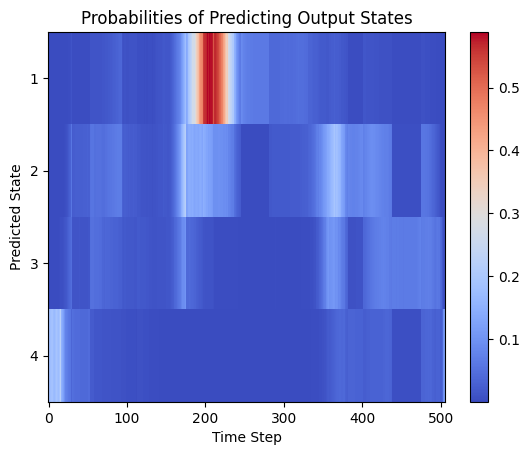

In [186]:
# Define the labels for the y-axis (predicted states)
y_labels = ['1','2','3','4']

# Create a figure and axis
fig, ax = plt.subplots()

# Create the heatmap plot
heatmap = ax.imshow(all_probs_array.T, cmap='coolwarm', aspect='auto', interpolation='none')

# Add colorbar
cbar = plt.colorbar(heatmap)

# Set the axis labels and title
ax.set_xlabel('Time Step')
ax.set_ylabel('Predicted State')
ax.set_title('Probabilities of Predicting Output States')

# Set the y-axis ticks and labels
ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels)

# Show the plot

AttributeError: 'list' object has no attribute 'columns'

In [209]:
all_probs_array = model_probabilities_sm['s_m10_val11']
y_val = scaled_df[scaled_df['trial'] == 11][['s_1', 's_2', 's_3', 's_4']]

In [201]:
y_val.shape

(518, 4)

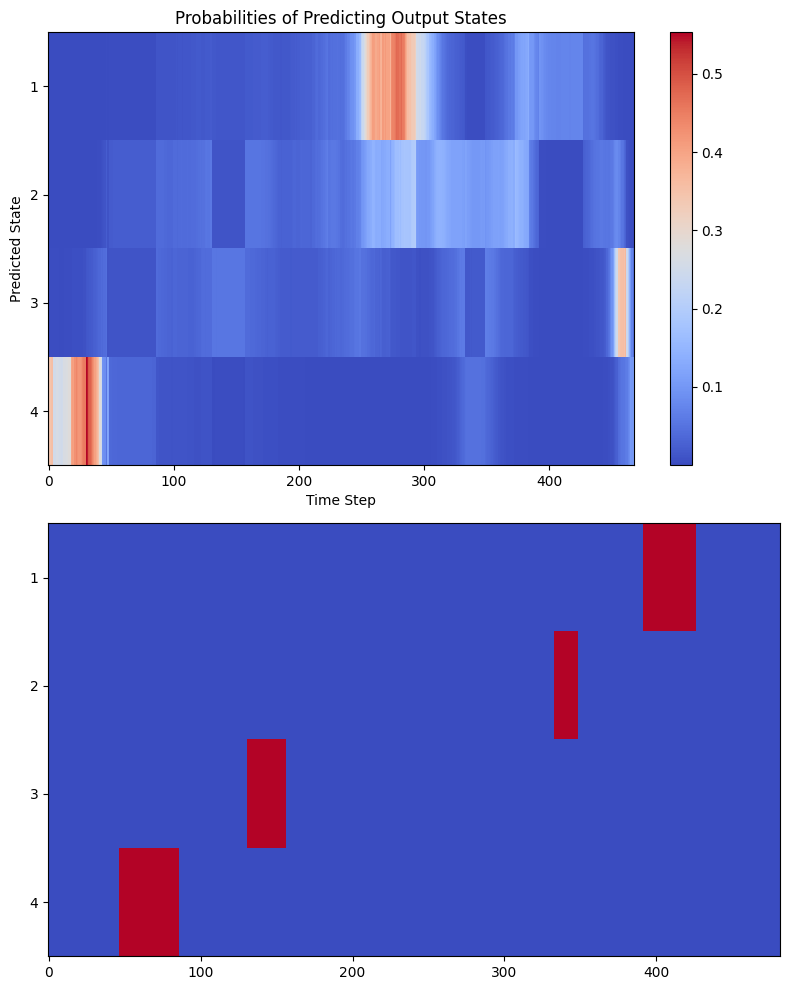

In [210]:
# Define the labels for the y-axis (predicted states)
y_labels = ['1', '2', '3', '4']

# Create a figure with a grid of subplots (2 rows, 1 column)
fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Create the heatmap plot in the first subplot
heatmap = axs[0].imshow(all_probs_array.T, cmap='coolwarm', aspect='auto', interpolation='none')
heatmap2 = axs[1].imshow(y_val.T, cmap='coolwarm', aspect='auto', interpolation='none')
# Add colorbar to the heatmap subplot
cbar = plt.colorbar(heatmap, ax=axs[0])

# Set the axis labels and title for the heatmap subplot
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Predicted State')
axs[0].set_title('Probabilities of Predicting Output States')

# Set the y-axis ticks and labels for the heatmap subplot
axs[0].set_yticks(np.arange(len(y_labels)))
axs[0].set_yticklabels(y_labels)
# Set the y-axis ticks and labels for the heatmap subplot
axs[1].set_yticks(np.arange(len(y_labels)))
axs[1].set_yticklabels(y_labels)
""" 
# Create the second plot (line plot) in the second subplot
axs[1].plot(np.arange(len(y_val)), y_val, color='green', label='Actual Values')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Actual Value')
axs[1].set_title('Actual Test Values for Y')
axs[1].legend()
 """
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
actual_values = y_val
# Define the labels for the y-axis (predicted states)
y_labels = ['1', '2', '3', '4']

# Create a figure with a grid of subplots (2 rows, 1 column)
fig, axs = plt.subplots(2,1, figsize=(8,10))

# Create the first heatmap plot in the first subplot
heatmap1 = axs[0].imshow(all_probs_array.T, cmap='coolwarm', aspect='auto', interpolation='none')

# Add colorbar to the first heatmap subplot
cbar1 = plt.colorbar(heatmap1, ax=axs[0])

# Set the axis labels and title for the first heatmap subplot
#axs[0].set_xlabel('Time Step')
#axs[0].set_ylabel('Predicted State')
axs[0].set_title('Predicted States Probabilities')

# Set the y-axis ticks and labels for the first heatmap subplot
axs[0].set_yticks(np.arange(len(y_labels)))
axs[0].set_yticklabels(y_labels)

# Create the second heatmap plot in the second subplot
heatmap2 = axs[1].imshow(actual_values.T, cmap='coolwarm', aspect='auto', interpolation='none')

# Add colorbar to the second heatmap subplot
cbar2 = plt.colorbar(heatmap2, ax=axs[1])

# Set the axis labels and title for the second heatmap subplot
axs[1].set_xlabel('Time Step')
#axs[1].set_ylabel('Predicted State')
axs[1].set_title('True States')

# Set the y-axis ticks and labels for the second heatmap subplot
axs[1].set_yticks(np.arange(len(y_labels)))
axs[1].set_yticklabels(y_labels)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# gates and hidden states

In [ ]:
class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRUCell(input_dim, hidden_dim, bias=True)                
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_dim, hidden_dim) if i == 0 else nn.GRUCell(hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm outside GRU cells

        
        
    def forward(self, x, h=None, hidden_states=None):
        if h is None:
            h = torch.zeros(x.size(0), self.hidden_dim)  # Initialize hidden state for the single layer

        hidden_states = []  # Initialize a list to store hidden states at each time step

        for t in range(x.size(1)):
            input_t = x[:, t, :]
            h = self.gru(input_t, h)  # Update the hidden state for the single layer
            hidden_states.append(h)  # Append the hidden state for the current time step

        h = self.batch_norm(h)  # Apply batch normalization to the final hidden state
        out = self.fc(self.softplus(h))  # Calculate the output based on the final hidden state
        out = torch.sigmoid(out)
        out = torch.round(out)

        # Return the output and the list of hidden states for the entire sequence
        return out, h, hidden_states

In [ ]:
def train(dataloader, model, optimizer, loss_fn, scheduler=None, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device)
    model.train()
    predicted_probs = []
    predicted_labels = []
    hidden_states = []  # Initialize a list to store hidden states

    for x, y in dataloader:
        x = x.to(device).float()
        y = y.to(device).float()
        
        optimizer.zero_grad()
        
        out, last_hidden_states, hidden_states_batch = model(x)  # Collect hidden states here
        y_prob = torch.sigmoid(out)
        # Append the predicted probabilities to the list
        predicted_probs.append(y_prob.cpu().detach().numpy())
        loss = loss_fn(out, y)
        epoch_loss.append(loss.item())
        
        hidden_states.append(hidden_states_batch)  # Append hidden states to the list
        
        y_pred = torch.round(y_prob)
        epoch_correct += sum((y == y_pred).flatten()).item()
        epoch_total += y.numel()
        
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        predicted_labels.extend(zip(y_pred.cpu().detach().cpu().numpy(), y.cpu().numpy()))
        if scheduler:
            scheduler.step()
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs, hidden_states

In [ ]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device).float()
    model.eval()
    predicted_probs = []
    predicted_labels = []
    hidden_states = []  # Initialize a list to store hidden states

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device).float()
            y = y.to(device).float()
            
            out, last_hidden_states, hidden_states_batch = model(x)  # Collect hidden states here
            
            loss = loss_fn(out, y)
            epoch_loss.append(loss.item())
            
            hidden_states.append(hidden_states_batch)  # Append hidden states to the list
            
            y_pred = torch.sigmoid(out)
            predicted_probs.append(y_pred.cpu().detach().numpy())
            y_pred = torch.round(y_pred)
            epoch_correct += sum((y == y_pred).flatten())
            epoch_total += y.numel()
            predicted_labels.extend(zip(y_pred.cpu().numpy(), y.cpu().numpy()))
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs, hidden_states

In [ ]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, schedule_on_train=True, verbose=True):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    train_hidden_states, val_hidden_states = [], [] # Initialize lists to store hidden states
    
    for epoch in range(num_epochs):
        epoch_train_loss, epoch_train_acc, train_preds, train_probs, train_hidden = train(train_dataloader, model, optimizer, loss_fn, scheduler, device)
        
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        train_hidden_states.extend(train_hidden)  # Append hidden states to the list
        
        if val_dataloader is not None:
            epoch_val_loss, epoch_val_acc, val_preds, val_probs, val_hidden = validate(val_dataloader, model, loss_fn, device)
        
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            val_hidden_states.extend(val_hidden)  # Append hidden states to the list
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(epoch_train_acc if schedule_on_train or val_dataloader is None else epoch_val_acc)
            
        if epoch % 50 == 0:
            val_str = f", val loss: {epoch_val_loss}, val acc: {epoch_val_acc}" if val_dataloader is not None else ""
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, train acc: {epoch_train_acc}{val_str}")
        if epoch == num_epochs - 1:  # Store values only for the final epoch
            train_predicted_labels = train_preds
            #val_predicted_labels = val_preds
            train_probs_final = train_probs
            #val_probs_final = val_probs
            if val_dataloader is not None:
                val_predicted_labels = val_preds
                val_probs_final = val_probs

    if val_dataloader is not None:        
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, val_predicted_labels, train_probs_final, val_probs_final, train_hidden_states, val_hidden_states
    else: 
        return train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states

In [ ]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = path + "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['nose_x', 'nose_y', 'nose_z', 'headTop_x', 'headTop_y', 'headTop_z',
       'neck_x', 'neck_y', 'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z',
       'lEar_x', 'lEar_y', 'lEar_z', 'lShoulder_x', 'lShoulder_y',
       'lShoulder_z', 'lElbow_x', 'lElbow_y', 'lElbow_z', 'lWrist_x',
       'lWrist_y', 'lWrist_z', 'lHip_x', 'lHip_y', 'lHip_z', 'rEar_x',
       'rEar_y', 'rEar_z', 'rShoulder_x', 'rShoulder_y', 'rShoulder_z',
       'rElbow_x', 'rElbow_y', 'rElbow_z', 'rWrist_x', 'rWrist_y', 'rWrist_z',
       'rHip_x', 'rHip_y', 'rHip_z', 's_1', 's_2', 's_3', 's_4'],
      dtype='object')

In [ ]:
for x, y in train_dataloader:
        x = x.to(device).float()
        y = y.to(device).float()
        
        optimizer.zero_grad()
        
        out, last_hidden_states, batch_hidden_states = model(x)

In [ ]:
batch_hidden_states[0][0]

In [ ]:
print(batch_hidden_states[0][0].shape)

In [ ]:
hidden_states_array = batch_hidden_states[0][0].detach().numpy()
hidden_states_array = hidden_states_array.T 

In [ ]:
hidden_states_array.shape

In [ ]:
# Create a figure with a single subplot
fig, axs = plt.subplots(1, 1, figsize=(14,6))  # Adjust the figsize as needed

# Create the heatmap plot in the single subplot
heatmap = axs.imshow(hidden_states_array, cmap='coolwarm', aspect='auto', interpolation='none')

# Add colorbar to the heatmap subplot
cbar = plt.colorbar(heatmap, ax=axs)

# Set the axis labels and title for the heatmap subplot
axs.set_ylabel('hidden unit')
axs.set_xlabel('time step')
axs.set_title('Heatmap of hidden states')

# Adjust spacing between the subplot
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
scaled_df.shape[1]-2

In [ ]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =100
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [ ]:
shift_values = np.array([10,80,130])

In [ ]:
#hidden_states_all = []
hidden_states_dict = {}
for j in np.arange(1,16):
    for i in shift_values:
        shift = i
        set_values = j
        model_name = 's_m'+str(shift)+'_'+'val'+str(set_values)+'_gates'


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
        #print(X_train.shape[0])
        

        train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        
        #hidden_states_dict[(shift, set_values)] = train_hidden_states
        
        all_preds = []
        all_probs = []
        hidden_states = []

        # Iterate through the test data batches
        for inputs, _ in train_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, h, test_hidden_states = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)
            hidden_states.append(test_hidden_states)
        
        #print(hidden_states[0][0])    
        hidden_states_array = hidden_states[0][0].detach().numpy()
        hidden_states_array = hidden_states_array.T
        #print(hidden_states_array.shape) 
        
        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_train.columns, index=y_train.index)
        # Calculate accuracy for each output state
        
        # Create a figure with a single subplot
        fig, axs = plt.subplots(2, 1, figsize=(16,10))  # Adjust the figsize as needed

        # Create the heatmap plot in the single subplot
        heatmap = axs[0].imshow(hidden_states_array, cmap='seismic', aspect='auto', interpolation='none')

        # Add colorbar to the heatmap subplot
        #cbar = plt.colorbar(heatmap, ax=axs)

        # Set the axis labels and title for the heatmap subplot
        axs[0].set_ylabel('hidden unit')
        axs[0].set_xlabel('time step')
        axs[0].set_title('Heatmap of hidden states for s='+str(i)+' trial='+str(j))
        
        axs[1].imshow(all_probs_array.T, cmap='seismic', aspect='auto', interpolation='none')
        y_labels = ['1', '2', '3', '4']
        axs[1].set_yticks(np.arange(len(y_labels)))
        axs[1].set_yticklabels(y_labels)
        
        # Add colorbar to the heatmap subplot
        #cbar = plt.colorbar(heatmap, ax=axs)
        plot_title = 'solo_s'+str(i)+'_val'+str(j)
        #plt.title(plot_title)
        # Set the axis labels and title for the heatmap subplot
        axs[0].set_ylabel('predictions')
        axs[0].set_xlabel('time step')
        #axs[0].set_title()
        # Adjust spacing between the subplot
        plt.tight_layout()
        # Show the plot
        # Specify the file path
        # Specify the directory where you want to save the plots
        save_directory = r'C:\Users\kacpe\Desktop\study\research lab\lab_rotation_git\hidden_states_heatmaps_train'

        # Create the directory if it doesn't exist
        os.makedirs(save_directory, exist_ok=True)

        # Define the plot title
        plot_title = f'solo_s{i}_val{j}'

        # Specify the file path using os.path.join
        file_path = os.path.join(save_directory, f'{plot_title}.png')

        # Save the plot to the specified path
        fig.savefig(file_path)
        #plt.show()
        plt.close()
                
        
       
    
    

Epoch 0, train loss: 0.99318927526474, train acc: 0.6004935459377373
Epoch 50, train loss: 0.08497070521116257, train acc: 0.9844343204252088
Epoch 0, train loss: 0.43113425374031067, train acc: 0.8743532560214095
Epoch 50, train loss: 0.18211303651332855, train acc: 0.9378679750223016
Epoch 0, train loss: 0.3486967086791992, train acc: 0.8874617737003058
Epoch 50, train loss: 0.2525496780872345, train acc: 0.904638124362895
Epoch 0, train loss: 0.43490543961524963, train acc: 0.9182550115018074
Epoch 50, train loss: 0.07446524500846863, train acc: 0.9850065724613868
Epoch 0, train loss: 0.3527289927005768, train acc: 0.8772032902467685
Epoch 50, train loss: 0.20687879621982574, train acc: 0.9199471210340776
Epoch 0, train loss: 0.3726874589920044, train acc: 0.8681343622333182
Epoch 50, train loss: 0.34488749504089355, train acc: 0.8746028143440763
Epoch 0, train loss: 0.20412753522396088, train acc: 0.9521866582158136
Epoch 50, train loss: 0.16878153383731842, train acc: 0.9604262398

In [ ]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =100
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [ ]:
#hidden_states_all = []
hidden_states_dict = {}
for j in np.arange(13,15):
    for i in shift_values:
        shift = i
        set_values = j
        model_name = 's_m'+str(shift)+'_'+'val'+str(set_values)+'_gates'


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
        #print(X_train.shape[0])
        

        train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        
        #hidden_states_dict[(shift, set_values)] = train_hidden_states
        
        all_preds = []
        all_probs = []
        hidden_states = []

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, h, test_hidden_states = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)
            hidden_states.append(test_hidden_states)
        
        #print(hidden_states[0][0])    
        hidden_states_array = hidden_states[0][0].detach().numpy()
        hidden_states_array = hidden_states_array.T
        #print(hidden_states_array.shape) 
        
        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()
        h_name = 'hidden_s'+str(i)+'_trial'+str(j)
        p_name = 'probs_s'+str(i)+'_trial'+str(j)
        np.save(h_name, hidden_states_array)
        np.save(p_name, all_probs_array)



                
        
       
    
    

Epoch 0, train loss: 0.14604417979717255, train acc: 0.9692057704502219
Epoch 50, train loss: 0.14604417979717255, train acc: 0.9692057704502219
Epoch 0, train loss: 0.19220440089702606, train acc: 0.9305086336336337
Epoch 50, train loss: 0.19220440089702606, train acc: 0.9305086336336337
Epoch 0, train loss: 0.32724639773368835, train acc: 0.8729472774416595
Epoch 50, train loss: 0.32724639773368835, train acc: 0.8729472774416595
Epoch 0, train loss: 0.14533913135528564, train acc: 0.9692511225144324
Epoch 50, train loss: 0.14533913135528564, train acc: 0.9692511225144324
Epoch 0, train loss: 0.19234581291675568, train acc: 0.9297945205479452
Epoch 50, train loss: 0.19234581291675568, train acc: 0.9297945205479452
Epoch 0, train loss: 0.3151167333126068, train acc: 0.8735733099209834
Epoch 50, train loss: 0.3151167333126068, train acc: 0.8735733099209834


In [ ]:
np.save('hidden_states.npy', hidden_states_array)

In [ ]:
first_value = list(hidden_states_dict.values())[0]
type(first_value)
hidden_states_array = first_value[0][0].detach().numpy()
hidden_states_array = hidden_states_array.T 

In [ ]:
# Create a figure with a single subplot
fig, axs = plt.subplots(2, 1, figsize=(14,6))  # Adjust the figsize as needed

# Create the heatmap plot in the single subplot
heatmap = axs[0].imshow(hidden_states_array, cmap='seismic', aspect='auto', interpolation='none')

# Add colorbar to the heatmap subplot
cbar = plt.colorbar(heatmap, ax=axs)

# Set the axis labels and title for the heatmap subplot
axs[0].set_ylabel('hidden unit')
axs[0].set_xlabel('time step')
axs[0].set_title('Heatmap of hidden states')



# Adjust spacing between the subplot
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        torch.save(state_dict, full_model)

# gradients

In [ ]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file_path = os.path.join(data_folder, "data_model_v3.csv")
df = pd.read_csv(file_path)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns

columns_to_shift

Index(['nose_x', 'nose_y', 'nose_z', 'headTop_x', 'headTop_y', 'headTop_z',
       'neck_x', 'neck_y', 'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z',
       'lEar_x', 'lEar_y', 'lEar_z', 'lShoulder_x', 'lShoulder_y',
       'lShoulder_z', 'lElbow_x', 'lElbow_y', 'lElbow_z', 'lWrist_x',
       'lWrist_y', 'lWrist_z', 'lHip_x', 'lHip_y', 'lHip_z', 'rEar_x',
       'rEar_y', 'rEar_z', 'rShoulder_x', 'rShoulder_y', 'rShoulder_z',
       'rElbow_x', 'rElbow_y', 'rElbow_z', 'rWrist_x', 'rWrist_y', 'rWrist_z',
       'rHip_x', 'rHip_y', 'rHip_z', 's_1', 's_2', 's_3', 's_4'],
      dtype='object')

In [ ]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =10
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, mode="min", patience=5)

In [ ]:
print(GRUCellNet.forward)

<function GRUCellNet.forward at 0x000001948FC91670>


In [ ]:
#hidden_states_all = []
hidden_states_dict = {}
predictions_dict_sm = {}

for j in np.arange(12,13):
    for i in np.arange(10,11,10):
        shift = i
        set_values = j
        model_name = 's_m'+str(shift)+'_'+'val'+str(set_values)+'_gates'


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])
        
        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        #print(X_train.columns)
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 
        #print(X_train.columns)
        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
        #print(X_train.shape[0])
        

        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)
        
        
        
        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models_gradient/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
        

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()
        # Construct the key for the combination
        key = f"sm_shift{shift}_set{set_values}"

        # Store the predictions as NumPy arrays in the dictionary
        predictions_dict_sm[key] = all_preds_array 

        print(model_name)
        print(np.mean(accuracies))


#

Epoch 0, train loss: 1.093435525894165, train acc: 0.41514227642276424
s_m10_val12_gates
0.7213235294117647


In [ ]:
# Assuming you have a dictionary named predictions_dict
# and you want to extract values associated with the first key
first_key = next(iter(predictions_dict_sm))  # Get the first key

# Access the values associated with the first key
values_for_first_key = predictions_dict_sm[first_key]

In [ ]:
print(first_key)
print(values_for_first_key)

sm_shift10_set12
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 ...
 [1. 1. 1. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 0.]]


In [ ]:
y_hat = values_for_first_key
len(y_hat)

340

In [ ]:
file = "y_tilda.csv"


y_tilda = pd.read_csv(file)
y_tilda = y_tilda[y_tilda['trial']==12].drop(columns=['trial','id'])
#y_tilda = y_tilda.to_numpy()

In [ ]:
y_tilda.shape

(350, 4)

In [ ]:
# Create an empty DataFrame to store the shifted data
file_path = os.path.join(data_folder, "data_model_v3.csv")
y_tilda = pd.read_csv(file_path)
y_tilda = y_tilda[y_tilda['trial']==12].drop(columns=['trial','id'])
shift = 10 
col_shift = ['s_1', 's_2', 's_3', 's_4']
# Loop through unique trial values
    # Create shifted columns for each column in columns_to_shift
for col in col_shift:
    new_col_name = col + '_minus_' + str(shift)
    y_tilda[new_col_name] = y_tilda[col].shift(shift)

# Drop the last 'i' records for each trial
y_tilda = y_tilda.dropna()
print(y_tilda.columns)
y_tilda = y_tilda.drop(columns=['s_1', 's_2', 's_3', 's_4'])
new_column_names = {'s_1_minus_10': 's_1',
                    's_2_minus_10': 's_2',
                    's_3_minus_10': 's_3',
                    's_4_minus_10': 's_4'}

y_tilda = y_tilda.rename(columns=new_column_names)
y_tilda = y_tilda.to_numpy()
print(y_tilda.shape)
y_tilda = torch.tensor(y_tilda)
y_hat = torch.tensor(y_hat, dtype=torch.float32, requires_grad=True)
y_tilda = torch.tensor(y_tilda, dtype=torch.float32, requires_grad=True)
#y_hat = torch.tensor(y_hat)

Index(['s_1', 's_2', 's_3', 's_4', 's_1_minus_10', 's_2_minus_10',
       's_3_minus_10', 's_4_minus_10'],
      dtype='object')
(340, 4)


In [ ]:
y_hat = torch.tensor(y_hat, dtype=torch.float32, requires_grad=True)
y_tilda = torch.tensor(y_tilda, dtype=torch.float32, requires_grad=True)

C:\Users\kacpe\AppData\Local\Temp\ipykernel_23732\2719183788.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tilda = torch.tensor(y_tilda, dtype=torch.float32, requires_grad=True)


In [ ]:
(X_test.columns)

Index(['nose_x_minus_10', 'nose_y_minus_10', 'nose_z_minus_10',
       'headTop_x_minus_10', 'headTop_y_minus_10', 'headTop_z_minus_10',
       'neck_x_minus_10', 'neck_y_minus_10', 'neck_z_minus_10',
       'tailBase_x_minus_10', 'tailBase_y_minus_10', 'tailBase_z_minus_10',
       'lEar_x_minus_10', 'lEar_y_minus_10', 'lEar_z_minus_10',
       'lShoulder_x_minus_10', 'lShoulder_y_minus_10', 'lShoulder_z_minus_10',
       'lElbow_x_minus_10', 'lElbow_y_minus_10', 'lElbow_z_minus_10',
       'lWrist_x_minus_10', 'lWrist_y_minus_10', 'lWrist_z_minus_10',
       'lHip_x_minus_10', 'lHip_y_minus_10', 'lHip_z_minus_10',
       'rEar_x_minus_10', 'rEar_y_minus_10', 'rEar_z_minus_10',
       'rShoulder_x_minus_10', 'rShoulder_y_minus_10', 'rShoulder_z_minus_10',
       'rElbow_x_minus_10', 'rElbow_y_minus_10', 'rElbow_z_minus_10',
       'rWrist_x_minus_10', 'rWrist_y_minus_10', 'rWrist_z_minus_10',
       'rHip_x_minus_10', 'rHip_y_minus_10', 'rHip_z_minus_10', 's_1_minus_10',
       's_2_m

In [ ]:
# Assuming you have 'y_hat' and 'y_tilda' as tensors containing binary values (0 or 1)
y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float

y_hat = y_hat.requires_grad_(True)
y_tilda = y_tilda.requires_grad_(True)

# Define the loss function
loss_fn = nn.BCELoss()

# Calculate the loss
binary_cross_entropy_loss = loss_fn(y_hat, y_tilda)
input = torch.tensor(X_test.values)
input = input.unsqueeze(1)
input = input.float()
# set input to require_grad
input = input.requires_grad_(True)
model.eval()
output, f = model(input)

# calculating loss 
output = output.requires_grad_(True)
loss_fn = nn.BCEWithLogitsLoss()
loss = loss_fn(output, y_tilda)
loss.backward()
#print(input)

# Access the gradients for the input data
input_gradients = input.grad.squeeze(1)
print(input_gradients.shape)

torch.Size([340, 46])


C:\Users\kacpe\AppData\Local\Temp\ipykernel_23732\3382397077.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat = torch.tensor(y_hat, dtype=torch.float32)  # Convert to float
C:\Users\kacpe\AppData\Local\Temp\ipykernel_23732\3382397077.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tilda = torch.tensor(y_tilda, dtype=torch.float32)  # Convert to float


In [ ]:
X_test.columns[-10]

'rWrist_x_minus_10'

In [ ]:
lWrist_x_gradient = input_gradients[:,21].numpy()
rWrist_x_gradient = input_gradients[:,-10].numpy()

In [ ]:
rWrist_x_gradient

array([-1.76474368e-05, -1.76542217e-05, -1.75890345e-05, -1.53147794e-05,
       -1.52373414e-05, -1.54065729e-05, -1.53684487e-05, -1.54638383e-05,
       -1.53771980e-05, -1.53767942e-05, -1.53613546e-05, -1.53780456e-05,
       -1.53096698e-05, -1.47437058e-05, -1.50416718e-05, -1.48826812e-05,
       -1.49087191e-05, -1.49521038e-05, -1.48654781e-05, -1.52426392e-05,
       -1.53065903e-05, -1.53166438e-05, -1.54639529e-05, -1.53494366e-05,
       -1.54897043e-05, -1.54544141e-05, -1.55553607e-05, -1.59791598e-05,
       -1.61623902e-05, -1.58945604e-05, -1.63379354e-05, -1.60139989e-05,
       -1.59030424e-05, -1.59875017e-05, -1.52859720e-05, -1.52791599e-05,
       -1.53782294e-05, -1.55587986e-05, -1.56673359e-05, -1.57688792e-05,
       -1.58552466e-05,  1.39490121e-05,  1.40369311e-05,  1.40971624e-05,
        1.41446872e-05,  1.42036261e-05,  1.42420649e-05,  1.45333961e-05,
        1.45750673e-05,  1.45582308e-05,  1.47301071e-05,  1.47653136e-05,
        1.48840008e-05,  

In [ ]:
np.sum(rWrist_x_gradient > lWrist_x_gradient)/len(rWrist_x_gradient)

0.8794117647058823

In [ ]:
# Define the folder and model filename
load_folder = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/gradient_models'
model_filename = 's_m80_val13_gates.pth'

# Iterate through the test data batches
for inputs, _ in train_dataloader:
    inputs = inputs.float()
    inputs.requires_grad = True  # Set requires_grad to True
    # Forward pass to get predictions
    with torch.no_grad():
        predictions, h, test_hidden_states = model(inputs)
        probabilities = torch.sigmoid(predictions)
        output = torch.round(probabilities)
inputs.grad

In [ ]:
output

tensor([[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.]])

In [ ]:
model(input)[0]

tensor([[15.5881, 17.0496,  7.1234, -2.7169],
        [15.6907, 16.8004,  7.1833, -2.5166],
        [14.9813, 15.7438,  6.8294, -2.4401],
        ...,
        [ 5.0684,  3.3052, -4.5890, -2.3956],
        [ 5.0625,  3.1659, -4.4379, -2.1808],
        [ 5.0584,  3.2695, -4.3667, -2.2210]], grad_fn=<AddmmBackward0>)

In [ ]:

input = torch.tensor(X_train.values)
input = input.unsqueeze(1)
input = input.float()
input.shape 

torch.Size([5328, 1, 46])

In [ ]:
output

(tensor([[15.5881, 17.0496,  7.1234, -2.7169],
         [15.6907, 16.8004,  7.1833, -2.5166],
         [14.9813, 15.7438,  6.8294, -2.4401],
         ...,
         [ 5.0684,  3.3052, -4.5890, -2.3956],
         [ 5.0625,  3.1659, -4.4379, -2.1808],
         [ 5.0584,  3.2695, -4.3667, -2.2210]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1361, -3.9054,  4.3457,  ...,  6.9570, -0.9351, -1.0151],
         [-0.1834, -3.3678,  4.3394,  ...,  6.9214, -0.8772, -1.2564],
         [-0.1403, -3.1291,  3.9980,  ...,  6.4979, -0.8859, -1.4158],
         ...,
         [-0.8940,  0.8611, -0.3193,  ...,  0.0296,  2.5547,  2.2299],
         [-0.8732,  0.9012, -0.3054,  ...,  0.0481,  2.5995,  1.8107],
         [-0.8328,  0.9142, -0.3030,  ...,  0.0511,  2.5933,  1.5676]],
        grad_fn=<NativeBatchNormBackward0>),
 [tensor([[ 0.0378,  0.0049,  0.0404,  ...,  0.1942,  0.0496, -0.3348],
          [ 0.0359,  0.0124,  0.0403,  ...,  0.1932,  0.0511, -0.3366],
          [ 0.0376,  0.0157,  0.0368,  ...,  0

In [ ]:
output.size

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
model(input)

(tensor([[15.6528, 16.5354,  6.8842, -2.5370],
         [15.7095, 16.3226,  6.9530, -2.3735],
         [15.0120, 15.2652,  6.5979, -2.3344],
         ...,
         [ 4.9547,  3.1134, -4.5596, -2.0263],
         [ 4.9473,  2.9779, -4.4284, -1.8249],
         [ 4.9355,  3.0609, -4.3583, -1.8576]], grad_fn=<AddmmBackward0>),
 tensor([[-0.2498, -4.0778,  4.4233,  ...,  6.9959, -0.7348, -1.3482],
         [-0.2950, -3.5366,  4.4125,  ...,  6.9596, -0.6890, -1.5728],
         [-0.2455, -3.2876,  4.0599,  ...,  6.5503, -0.7003, -1.6831],
         ...,
         [-0.8525,  0.8381, -0.3202,  ..., -0.0396,  2.6897,  2.1940],
         [-0.8352,  0.8757, -0.3068,  ..., -0.0204,  2.7345,  1.8132],
         [-0.7982,  0.8865, -0.3056,  ..., -0.0164,  2.7295,  1.5923]],
        grad_fn=<NativeBatchNormBackward0>),
 [tensor([[ 0.0308,  0.0021,  0.0413,  ...,  0.2176,  0.0700, -0.3320],
          [ 0.0290,  0.0097,  0.0412,  ...,  0.2165,  0.0713, -0.3338],
          [ 0.0310,  0.0132,  0.0376,  ...,  0

In [ ]:
output

(tensor([[15.5881, 17.0496,  7.1234, -2.7169],
         [15.6907, 16.8004,  7.1833, -2.5166],
         [14.9813, 15.7438,  6.8294, -2.4401],
         ...,
         [ 5.0684,  3.3052, -4.5890, -2.3956],
         [ 5.0625,  3.1659, -4.4379, -2.1808],
         [ 5.0584,  3.2695, -4.3667, -2.2210]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1361, -3.9054,  4.3457,  ...,  6.9570, -0.9351, -1.0151],
         [-0.1834, -3.3678,  4.3394,  ...,  6.9214, -0.8772, -1.2564],
         [-0.1403, -3.1291,  3.9980,  ...,  6.4979, -0.8859, -1.4158],
         ...,
         [-0.8940,  0.8611, -0.3193,  ...,  0.0296,  2.5547,  2.2299],
         [-0.8732,  0.9012, -0.3054,  ...,  0.0481,  2.5995,  1.8107],
         [-0.8328,  0.9142, -0.3030,  ...,  0.0511,  2.5933,  1.5676]],
        grad_fn=<NativeBatchNormBackward0>),
 [tensor([[ 0.0378,  0.0049,  0.0404,  ...,  0.1942,  0.0496, -0.3348],
          [ 0.0359,  0.0124,  0.0403,  ...,  0.1932,  0.0511, -0.3366],
          [ 0.0376,  0.0157,  0.0368,  ...,  0

In [ ]:
model(input)

(tensor([[15.5881, 17.0496,  7.1234, -2.7169],
         [15.6907, 16.8004,  7.1833, -2.5166],
         [14.9813, 15.7438,  6.8294, -2.4401],
         ...,
         [ 5.0684,  3.3052, -4.5890, -2.3956],
         [ 5.0625,  3.1659, -4.4379, -2.1808],
         [ 5.0584,  3.2695, -4.3667, -2.2210]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1361, -3.9054,  4.3457,  ...,  6.9570, -0.9351, -1.0151],
         [-0.1834, -3.3678,  4.3394,  ...,  6.9214, -0.8772, -1.2564],
         [-0.1403, -3.1291,  3.9980,  ...,  6.4979, -0.8859, -1.4158],
         ...,
         [-0.8940,  0.8611, -0.3193,  ...,  0.0296,  2.5547,  2.2299],
         [-0.8732,  0.9012, -0.3054,  ...,  0.0481,  2.5995,  1.8107],
         [-0.8328,  0.9142, -0.3030,  ...,  0.0511,  2.5933,  1.5676]],
        grad_fn=<NativeBatchNormBackward0>),
 [tensor([[ 0.0378,  0.0049,  0.0404,  ...,  0.1942,  0.0496, -0.3348],
          [ 0.0359,  0.0124,  0.0403,  ...,  0.1932,  0.0511, -0.3366],
          [ 0.0376,  0.0157,  0.0368,  ...,  0

In [ ]:
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])

In [ ]:
# y_tilda instead of target 
#output = y_hat 
# creating input
input = torch.tensor(X_test.values)
input = input.unsqueeze(1)
input = input.float()
# set input to require_grad
input = input.requires_grad_(True)
model.eval()
output, f, f = model(input)

# calculating loss 
output = output.requires_grad_(True)
loss = loss_fn(output, target)
loss.backward()

# Access the gradients for the input data
input_gradients = input.grad.squeeze(1)

In [ ]:
input_gradients

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
input.grad.squeeze(1)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
        # Define the folder and model filename
load_folder = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/gradient_models'
model_filename = 's_m80_val13_gates.pth'

# Load the model
checkpoint = torch.load(os.path.join(load_folder, model_filename))
model.load_state_dict(checkpoint)

# Set the model in evaluation mode
model.eval()
# Set the model in evaluation mode


# Access the model's state dictionary
model_state_dict = model.state_dict()

# Now you can access the weights of the nn.GRUCell layers
gru_cell_weights = {
    key: value
    for key, value in model_state_dict.items()
    if key.startswith('gru_cells.')
}
print(len(gru_cell_weights))
# Print or access the weights as needed
for key, value in gru_cell_weights.items():
    print(key)
    print(value)
    


# Extract and assign the weights to separate variables
weight_ih = gru_cell_weights['gru_cells.0.weight_ih']
weight_hh = gru_cell_weights['gru_cells.0.weight_hh']


4
gru_cells.0.weight_ih
tensor([[ 0.1454, -0.0767,  0.1165,  ...,  0.0882,  0.0758,  0.0415],
        [ 0.0745, -0.1682,  0.0754,  ...,  0.0346, -0.0484, -0.1178],
        [-0.0083, -0.1615,  0.1327,  ...,  0.0147, -0.1474, -0.1203],
        ...,
        [ 0.0235, -0.0237, -0.0839,  ...,  0.0383, -0.1634,  0.1645],
        [-0.0403,  0.0512,  0.0946,  ..., -0.0186,  0.1682,  0.1391],
        [ 0.1168, -0.0078, -0.1271,  ..., -0.0558,  0.1122,  0.0342]])
gru_cells.0.weight_hh
tensor([[ 0.0654,  0.0306,  0.1648,  ..., -0.0643,  0.1707,  0.0210],
        [-0.0169,  0.1101,  0.0372,  ...,  0.0406, -0.0684,  0.0486],
        [ 0.1226, -0.1662, -0.0386,  ...,  0.0828,  0.0141, -0.0264],
        ...,
        [ 0.1211, -0.1242,  0.1029,  ...,  0.0835,  0.0161,  0.0562],
        [-0.0618, -0.0938, -0.0629,  ...,  0.0225,  0.1529, -0.1611],
        [-0.0711,  0.0437, -0.0786,  ...,  0.0553,  0.0523,  0.1267]])
gru_cells.0.bias_ih
tensor([-0.0448, -0.1460, -0.1346,  0.0724, -0.1092, -0.0197,  0.0

In [ ]:
len(weight_ih[0])

46

In [ ]:
weight_ih_np = weight_ih.numpy()

In [ ]:
features = ['nose_x_minus_80', 'nose_y_minus_80', 'nose_z_minus_80',
       'headTop_x_minus_80', 'headTop_y_minus_80', 'headTop_z_minus_80',
       'neck_x_minus_80', 'neck_y_minus_80', 'neck_z_minus_80',
       'tailBase_x_minus_80', 'tailBase_y_minus_80', 'tailBase_z_minus_80',
       'lEar_x_minus_80', 'lEar_y_minus_80', 'lEar_z_minus_80',
       'lShoulder_x_minus_80', 'lShoulder_y_minus_80', 'lShoulder_z_minus_80',
       'lElbow_x_minus_80', 'lElbow_y_minus_80', 'lElbow_z_minus_80',
       'lWrist_x_minus_80', 'lWrist_y_minus_80', 'lWrist_z_minus_80',
       'lHip_x_minus_80', 'lHip_y_minus_80', 'lHip_z_minus_80',
       'rEar_x_minus_80', 'rEar_y_minus_80', 'rEar_z_minus_80',
       'rShoulder_x_minus_80', 'rShoulder_y_minus_80', 'rShoulder_z_minus_80',
       'rElbow_x_minus_80', 'rElbow_y_minus_80', 'rElbow_z_minus_80',
       'rWrist_x_minus_80', 'rWrist_y_minus_80', 'rWrist_z_minus_80',
       'rHip_x_minus_80', 'rHip_y_minus_80', 'rHip_z_minus_80', 's_1_minus_80',
       's_2_minus_80', 's_3_minus_80', 's_4_minus_80']

In [ ]:
weight_ih_np.shape

(102, 46)

In [ ]:
weights = pd.DataFrame(weight_ih_np, columns=features)

In [ ]:
weights['rWrist_x_minus_80']

0     -0.118293
1      0.057691
2     -0.099260
3      0.020036
4      0.046773
         ...   
97    -0.108127
98    -0.147265
99     0.120991
100   -0.109019
101    0.127330
Name: rWrist_x_minus_80, Length: 102, dtype: float32

In [ ]:
weights['lWrist_x_minus_80']

0      0.073618
1      0.129745
2     -0.052349
3      0.136418
4      0.078713
         ...   
97    -0.137238
98    -0.041288
99    -0.127240
100   -0.085322
101   -0.029799
Name: lWrist_x_minus_80, Length: 102, dtype: float32

In [ ]:
# Hyperparameters
input_dim = 1
hidden_dim = 1
output_dim = 4
num_layers = 1
n_epochs =151
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [ ]:
rwrist_df = scaled_df[['rWrist_x','trial','id','s_1','s_2','s_3','s_4']]
lwrist_df = scaled_df[['lWrist_x','trial','id','s_1','s_2','s_3','s_4']]
labels = ['s_1','s_2','s_3','s_4']

In [ ]:
y_train.to_numpy()

array([[1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       ...,
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [ ]:
output.shape

torch.Size([5328, 4])

In [ ]:
rWrist_loss.requires_grad_(True)

tensor(0.8470, dtype=torch.float64, requires_grad=True)

In [ ]:
load_folder = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/gradient_models'
model_filename = 's_m80_val13_gates.pth'

# Load the model
checkpoint = torch.load(os.path.join(load_folder, model_filename))
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
#filtered_df = scaled_df[scaled_df['trial'] != 14]
#target = filtered_df[['s_1','s_2','s_3','s_4']] 
target = torch.from_numpy(y_test.to_numpy())
target.shape

torch.Size([5328, 4])

In [ ]:
input.grad

AttributeError: 'function' object has no attribute 'grad'

In [ ]:
model_loss = loss_fn(output, target)
model_loss.requires_grad_(True)
model_loss.backward()


# Access gradients for specific parameters
gru_weight_ih_gradients = model.gru.weight_ih.grad  # Gradients for input-hidden weights of GRU
gru_weight_hh_gradients = model.gru.weight_hh.grad  # Gradients for hidden-hidden weights of GRU
linear_weight_gradients = model.fc.weight.grad  # Gradients for the weight of the linear layer

In [ ]:
model_loss

tensor(0.6458, dtype=torch.float64, requires_grad=True)

In [ ]:
gradients_array = gru_weight_ih_gradients.numpy()
gradients = pd.DataFrame(gradients_array, columns=features)
gradients[['rWrist_x_minus_80','lWrist_x_minus_80']]



,rWrist_x_minus_80,lWrist_x_minus_80
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
97,0.0,0.0
98,0.0,0.0
99,0.0,0.0
100,0.0,0.0


In [ ]:
np.round(np.mean(np.round(gradients['rWrist_x_minus_80'] - gradients['lWrist_x_minus_80'],5)),15)

5.392157618e-06

In [ ]:
# Perform the backward pass on the combined loss
combined_loss = rWrist_loss + lWrist_loss
combined_loss.backward()
gradients = combined_loss.grad
print(gradients)

None


c:\Users\kacpe\anaconda3\lib\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\build\aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


In [ ]:
lWrist_gradients

tensor(1., dtype=torch.float64)

In [ ]:
        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, h, test_hidden_states = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

In [ ]:
        # Define the folder and model filename
load_folder = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/gradient_models'
model_filename = 'lWrist_model.pth'

# Load the model
checkpoint = torch.load(os.path.join(load_folder, model_filename))
model.load_state_dict(checkpoint)

# Set the model in evaluation mode
model.eval()
# Set the model in evaluation mode


# Access the model's state dictionary
model_state_dict = model.state_dict()

# Now you can access the weights of the nn.GRUCell layers
gru_cell_weights = {
    key: value
    for key, value in model_state_dict.items()
    if key.startswith('gru_cells.')
}

    


# Extract and assign the weights to separate variables
lWrist_weights_ih = gru_cell_weights['gru_cells.0.weight_ih']
lWrist_weights_hh = gru_cell_weights['gru_cells.0.weight_hh']


        # Define the folder and model filename
load_folder = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/gradient_models'
model_filename = 'rWrist_model.pth'

# Load the model
checkpoint = torch.load(os.path.join(load_folder, model_filename))
model.load_state_dict(checkpoint)

# Set the model in evaluation mode
model.eval()
# Set the model in evaluation mode


# Access the model's state dictionary
model_state_dict = model.state_dict()

# Now you can access the weights of the nn.GRUCell layers
gru_cell_weights = {
    key: value
    for key, value in model_state_dict.items()
    if key.startswith('gru_cells.')
}

    


# Extract and assign the weights to separate variables
rWrist_weights_ih = gru_cell_weights['gru_cells.0.weight_ih']
rWrist_weights_hh = gru_cell_weights['gru_cells.0.weight_hh']

RuntimeError: Error(s) in loading state_dict for GRUCellNet:
	size mismatch for gru.weight_ih: copying a param with shape torch.Size([3, 1]) from checkpoint, the shape in current model is torch.Size([102, 46]).
	size mismatch for gru.weight_hh: copying a param with shape torch.Size([3, 1]) from checkpoint, the shape in current model is torch.Size([102, 34]).
	size mismatch for gru.bias_ih: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([102]).
	size mismatch for gru.bias_hh: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([102]).
	size mismatch for fc.weight: copying a param with shape torch.Size([4, 1]) from checkpoint, the shape in current model is torch.Size([4, 34]).
	size mismatch for gru_cells.0.weight_ih: copying a param with shape torch.Size([3, 1]) from checkpoint, the shape in current model is torch.Size([102, 46]).
	size mismatch for gru_cells.0.weight_hh: copying a param with shape torch.Size([3, 1]) from checkpoint, the shape in current model is torch.Size([102, 34]).
	size mismatch for gru_cells.0.bias_ih: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([102]).
	size mismatch for gru_cells.0.bias_hh: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([102]).
	size mismatch for batch_norm.weight: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for batch_norm.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for batch_norm.running_mean: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([34]).
	size mismatch for batch_norm.running_var: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([34]).

In [ ]:
print(lWrist_weights_ih)
print(rWrist_weights_ih)

tensor([[ 0.6961],
        [ 0.6693],
        [-0.4421]])
tensor([[ 0.6961],
        [ 0.6693],
        [-0.4421]])


In [ ]:
rwrist_df = scaled_df[['rWrist_x','trial','id','s_1','s_2','s_3','s_4']]
lwrist_df = scaled_df[['lWrist_x','trial','id','s_1','s_2','s_3','s_4']]
labels = ['s_1','s_2','s_3','s_4']

#rwrist_df = lwrist_df.copy()
set_values = 13 
train_set = rwrist_df[rwrist_df['trial']!=set_values].drop(columns=['id', 'trial'])
test_set = rwrist_df[rwrist_df['trial']==set_values].drop(columns=['id', 'trial'])
full_set = rwrist_df.drop(columns=['id','trial'])

# split data into x and y 
X_train, y_train = train_set.drop(columns=labels), train_set[labels]
X_test, y_test = test_set.drop(columns=labels), test_set[labels]
X, y = full_set.drop(columns=labels), full_set[labels]
print(X_train.columns)
# reset index 
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
X, y = X.reset_index(drop=True), y.reset_index(drop=True) 
print(X_train.columns)
# Create custom datasets for training, validation, and testing
full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
#print(X_train.shape[0])


train_losses, train_accs, train_predicted_labels, train_probs_final, train_hidden_states = run_training(
    train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)


state_dict = model.state_dict()
folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/gradient_models' 
model_filename = 'rWrist_model.pth'  

# Combine the folder path and model filename
full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
torch.save(state_dict, full_model)

# Iterate through the test data batches
for inputs, _ in train_dataloader:
    inputs = inputs.float()
    inputs.requires_grad = True  # Set requires_grad to True
    # Forward pass to get predictions
    with torch.no_grad():
        predictions, h, test_hidden_states = model(inputs)
        probabilities = torch.sigmoid(predictions)
        rWrist_output = torch.round(probabilities)

Index(['rWrist_x'], dtype='object')
Index(['rWrist_x'], dtype='object')


RuntimeError: input has inconsistent input_size: got 1 expected 46

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def load_test_data(shift, set_values):
    """
    Function to load the test data based on shift and set values.

    Args:
    - shift: The shift value used to generate data.
    - set_values: The set value used to identify the test trial.

    Returns:
    - X_test: Test input data (features).
    - y_test: Test target labels.
    """
    # Placeholder implementation, replace this with your actual loading logic
    return X_test, y_test  # Replace with the actual data loading logic

def load_test_dataloader(model_name):
    """
    Extract shift and set_values from the model name, and load the corresponding test dataloader.

    Args:
    - model_name: The name of the model used to derive shift and set_values.

    Returns:
    - test_dataloader: DataLoader containing the test data.
    """
    # Extract `shift` and `set_values` from model name
    shift_value = int(model_name.split('_')[1][1:])  # Extract value after `s_m`
    set_value = int(model_name.split('_')[2][3:])    # Extract value after `val`

    # Load the corresponding test dataset
    X_test, y_test = load_test_data(shift_value, set_value)

    # Create the DataLoader with the test dataset
    test_dataset = MyDataset(torch.tensor(X_test), torch.tensor(y_test))
    return DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)

def evaluate_model(model, dataloader):
    """
    Evaluate the given model on the provided dataloader and produce probabilities.

    Args:
    - model: The PyTorch model to evaluate.
    - dataloader: DataLoader containing the test data.

    Returns:
    - probabilities_df: DataFrame containing output probabilities.
    """
    model.eval()
    all_probs = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.float()
            probabilities, _ = model(inputs)
            all_probs.append(probabilities.numpy())

    # Concatenate all batches
    all_probs_array = np.concatenate(all_probs, axis=0)

    # Adjust columns according to your model's output labels
    columns = ['s_1', 's_2', 's_3', 's_4']
    return pd.DataFrame(all_probs_array, columns=columns)

def load_and_evaluate_models_with_shift_10(model_directory):
    """
    Load models with shift value of 10 from the specified directory and evaluate them.

    Args:
    - model_directory: Directory containing the saved models.

    Returns:
    - model_probabilities: Dictionary mapping model names to their probabilities DataFrames.
    """
    model_probabilities = {}

    # Loop through each model file in the specified directory
    for model_filename in os.listdir(model_directory):
        if model_filename.endswith('.pth'):
            model_name = model_filename.replace('.pth', '')

            # Extract `shift` value
            shift_value = int(model_name.split('_')[1][1:])  # Extract value after `s_m`

            # Check if `shift` value is 10
            if shift_value == 10:
                model_path = os.path.join(model_directory, model_filename)

                # Load the model architecture (replace with your model class)
                model =   # Adjust to your actual model class
                model.load_state_dict(torch.load(model_path))

                # Load the relevant test data
                test_dataloader = load_test_dataloader(model_name)

                # Evaluate the model
                probabilities_df = evaluate_model(model, test_dataloader)

                # Store the results
                model_probabilities[model_name] = probabilities_df

    return model_probabilities

# Example usage
model_directory = 'models/'  # Adjust to your actual directory path
probabilities_dict = load_and_evaluate_models_with_shift_10(model_directory)

# Visualization (if desired)
import seaborn as sns
import matplotlib.pyplot as plt

for model_name, probabilities_df in probabilities_dict.items():
    plt.figure(figsize=(10, 6))
    sns.heatmap(probabilities_df, annot=True, fmt=".2f", cmap='Blues')
    plt.title(f"Probability Heatmap for Model: {model_name}")
    plt.show()